In [1]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
# include("Temperature.jl")
include("GridOperations.jl")
include("Topo.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Stefan Problem - test melting and solidification

Step 1 - import packages

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [2]:
# functions that relates entropy and temperature/pressure are define in TemperatureEntropy.jl file
include("TemperatureEntropy.jl")

ghost_nodes_center_TXS (generic function with 1 method)


Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [3]:
# functions that setup the initial condition for the stefan problem are define in TemperatureEntropy.jl file
function initial_ice_depth(x::Float64)
    return 1e4
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        # new([0.0,0.0,0.0],[1000.0,1000.0],[0.0,0.0,0.0],[4180.0,2100.0],[0.5610,2.2])
        # new([0.0,0.0,0.0],[1e3,9e2],[0.0,0.0,0.0],[4.18e3,2.1e3],[0.6,2.2])
        new([0.0],[9e2],[0.0],[2.1e3],[2.2])
        # new([0.0],[1e3],[0.0],[4.18e3],[0.6])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

# function update_marker_temp!(markers::Markers,materials::Materials)
#     T = markers.scalarFields["T"]
#     mmat = markers.integers[markers.integerFields["material"],:]
#     for i in 1:markers.nmark
#         if mmat[i] == 1 
#             markers.scalars[T,i] = 273.0
#         end 
#     end 
# end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["X"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    
    # Setting up Stefan conidtion
    lambda1 = get_lambda1(options)
    t = get_t(lambda1,options)
    
    # Note: the melt fraction is defining our layers or ice and water.
    # water - X = 1.0 
    # ice - X = 0.0
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        
        if my > hice # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = 273.0
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)

        elseif my < hice # icy shell
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = stefan_initial_condition(get_theta(my,t,lambda1),options)
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

In [13]:
function run(options::Dict)
    W = 1e4
    H = 2e4
    ny = 50
    nx = Int64(ceil(W/H*ny))
    gx = 0.0
    gy = 0.113
    
    # -1 = insulating, 1 = constant temp 
    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    materials = Materials()
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","Cp","Hr","kThermal","S","X"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers,materials,options)

    local time_plot = []
    local topography = []
    local topography_melt = []
    
    ### Setting up agruments for termination criteria ###
    max_step::Int64=300
    max_time::Float64=-1
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = dtmax
    # dt = 1e10
    
    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing
    Hr = nothing
    Cp_c = nothing
    # T = nothing
    # S = nothing
    # X = nothing
    dTmax = nothing
    dTemp = nothing
    Tnew = nothing
    Tlast = nothing
    kThermal = nothing
    Slast = nothing
    Xlast = nothing
    mat = nothing
    kThermal_vx = nothing
    kThermal_vy = nothing
    Xlast = nothing
    q_vx = nothing
    q_vy = nothing
    ocean_ice_interface = nothing
    initial_ocean_ice_interface = nothing
    
    itime = 1 
    terminate = false
    while !terminate
        # 0. update the markers properties
        update_marker_prop!(markers,materials)
        # update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        # eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic",method="logarithmic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,Hr_new,kThermal_new,Slast_new,Xlast_new, = marker_to_stag(markers,grid,["rho","Cp","alpha","Hr","kThermal","S","X"],"center")
        # interpolate temperature using rhocp as weight
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        kThermal_vx_new, = marker_to_stag(markers,grid,["kThermal",],"vx")
        kThermal_vy_new, = marker_to_stag(markers,grid,["kThermal",],"vy")

        if itime == 1 
            figure()
            title(L"Initial\,Temperature\,\,vs.\,\,Depth")
            plot(markers.x[2,1:markers.nmark]/1e3,markers.scalars[markers.scalarFields["T"],1:markers.nmark])
            gca().invert_yaxis()
            gca().set_ylabel(L"Temperature\,(K)")
            gca().set_xlabel(L"Depth\,(km)")
            show()
            
            figure()
            title(L"Initial\,Temperature")
            pcolor(grid.xc/1000,grid.yc/1000,Tlast_new)
            colorbar().set_label(label=L"K",rotation=0,labelpad=15)
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis() 
            gca().set_aspect("equal")
            tight_layout()
            show()

            figure()
            title(L"Initial\,Entropy")
            pcolor(grid.xc/1000,grid.yc/1000,Slast_new)
            colorbar().set_label(label=L"J/kg\cdot{K}",rotation=0,labelpad=15)
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show()

            figure()
            title(L"Initial\,Melt\,Fraction")
            cs = contour(grid.xc/1e3,grid.yc/1e3,Xlast_new,[0.5],colors="red")
            clabel(cs,inline=true,fontsize=8,fmt="Solidification boundary")
            pcolor(grid.xc/1e3,grid.yc/1e3,Xlast_new)
            colorbar(cmap="viridis")
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show() 
            
            # figure()
            # title(L"Initial\,Ocean-Ice\,Interface")
            # plot(grid.xc/1000,initial_ocean_ice_interface)
            # gca().set_ylabel(L"Height\,(km)")
            # gca().set_xlabel(L"Width\,(km)")
            # gca().invert_yaxis()
            # tight_layout()            
            # show()             
        end
        
        # deal with any NaN values from interpolation:
        if itime > 1
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
            replace_nan!(Slast,Slast_new)
            replace_nan!(kThermal_vx,kThermal_vx_new)
            replace_nan!(kThermal_vy,kThermal_vy_new)
            replace_nan!(Xlast,Xlast_new)
        end
        # Copy field data
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        Tlast = copy(Tlast_new)    
        Slast = copy(Slast_new)
        kThermal_vx = copy(kThermal_vx_new)
        kThermal_vy = copy(kThermal_vy_new)
        Xlast = copy(Xlast_new)

        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        diffusion_timestep = min((grid.x[2]-grid.x[1])^2 / 1e-6,(grid.y[2]-grid.y[1])^2 / 1e-6) / 2
        if this_dtmax > diffusion_timestep
            dt = diffusion_timestep
        else
            dt = this_dtmax
        end
    
        Tlast,Xlast = update_T_X_from_S(Slast,options)
        Tlast,Xlast,Slast = ghost_nodes_center_TXS(grid,Tlast,Xlast,Slast,Tbctype,Tbcval,options)
                
        # Initial guess for S
        Snew = copy(Slast)
        # Initial guess for T
        Tnew,Xnew = update_T_X_from_S(Snew,options)
        Tnew,Xnew,Snew = ghost_nodes_center_TXS(grid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
        
        println("norm of T_new = ",norm(Tnew))
        
        last_T_norm = NaN
        T_norm = NaN
        dT = nothing
        dTmax = Inf
        dS = nothing
        dSmax = Inf
        tolerance = 1e-12
        titer = 1 
        max_titer = 300
        for titer=1:max_titer
            println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")         
            # Computing conductive heat flux
            q_vx,q_vy = compute_q_cond(grid,Tnew,kThermal_vx,kThermal_vy) # W/m^2

            # Computing the new entropy
            Snew = compute_S_new(grid,Tnew,rho_c,Hr,q_vx,q_vy,Slast,dt);
            
            # Updating the new temperature and new melt fraction from the new entropy
            Tnew,Xnew = update_T_X_from_S(Snew,options)
            Tnew,Xnew,Snew = ghost_nodes_center_TXS(grid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
            T = copy(Tnew)
       
            if titer > 1
                last_T_norm = T_norm;
                T_norm = norm(Tnew[2:grid.ny,2:grid.nx]);
                println("[",titer,"]: Change in norm is :",T_norm - last_T_norm)
            else
                T_norm = norm(Tnew[2:end-1,2:end-1]);
            end
            
            # Computing the maximum temperature change
            dT = Tnew - Tlast
            dTmax = maximum(abs.(dT[2:grid.ny,2:grid.nx]))
            println("Maximum temperature change = $dTmax K")

            # Computing the maximum entropy change
            dS = Snew - Slast
            dSmax = maximum(abs.(dS[2:grid.ny,2:grid.nx]))
            println("Maximum Entropy change = $dSmax J/kg*K")

            # Printing dt
            println("dt = ",dt/seconds_in_year/1e3," kyr")
            if dTmax > 10.0
                dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)            
            # Checking for convergence:
            elseif titer > 1 && abs(T_norm-last_T_norm) < tolerance || dTmax < 10.0
                println("Converged after $titer iterations.")
                break
            end
        end
        
        # Updating entropy on the markers by projecting dS from the cell centers to the markers
        cell_center_change_to_markers!(markers,grid,dS,"S")

        ocean_ice_interface = get_interface(grid,-Xnew,-0.5)
        append!(topography,[ocean_ice_interface])
        # append!(topography_melt,[Xnew])
        append!(time_plot,time)

        if itime == max_step
            figure()
            title(L"Temperature\,\,vs.\,\,Depth")
            plot(markers.x[2,1:markers.nmark]/1e3,markers.scalars[markers.scalarFields["T"],1:markers.nmark])
            gca().invert_yaxis()
            gca().set_ylabel(L"Temperature\,(K)")
            gca().set_xlabel(L"Depth\,(km)")
            show()

            figure()
            title(L"Temperature\,\,at\,\,timestep\,=\,%$itime")
            pcolor(grid.xc/1e3,grid.yc/1e3,Tnew)
            colorbar().set_label(label=L"K",rotation=0,labelpad=15)
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show() 

            figure()
            title(L"Entropy\,\,at\,\,timestep\,=\,%$itime")
            pcolor(grid.xc/1e3,grid.yc/1e3,Snew)
            colorbar().set_label(label=L"J/kg\cdot{K}",rotation=0,labelpad=15)
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show()
            
            figure()
            title(L"Melt\,Fraction\,\,at\,\,timestep\,=\,%$itime")
            cs = contour(grid.xc/1e3,grid.yc/1e3,Xnew,[0.5],colors="red")
            clabel(cs,inline=true,fontsize=8,fmt="Solidification boundary")
            pcolor(grid.xc/1e3,grid.yc/1e3,Xnew)
            colorbar(cmap="viridis")
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show()
            
            # figure()
            # title(L"Ocean-Ice\,\,Interface\,\,at\,\,timestep\,=\,%$itime")
            # plot(grid.xc/1e3,initial_ocean_ice_interface,"-")
            # gca().set_ylabel(L"Height\,(km)")
            # gca().set_xlabel(L"Width\,(km)")
            # gca().invert_yaxis()
            # tight_layout()
            # show() 

            # figure()
            # title("Change in interface posistion")
            # plot(grid.xc/1e3,initial_ocean_ice_interface,"-",label="initial ice-ocean interface")
            # plot(grid.xc/1e3,ocean_ice_interface,"-",label="final ice-ocean interface")
            # gca().set_ylabel(L"Height\,(km)")
            # gca().set_xlabel(L"Width\,(km)")
            # gca().invert_yaxis()
            # # gca().set_aspect("equal")
            # tight_layout()
            # legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
            # show() 
        end
        
        # Checking Termination Criteria, time is in Myr, amplitude is in meters
        if time >= max_time || itime >= max_step 
            terminate = true
        end

        time += dt
        itime += 1
        println("Finished Step ",itime," time = ",time/seconds_in_year," yr, ",time/seconds_in_year/1e3," Kyr, ",time/seconds_in_year/1e6," Myr")  
    end
    return grid,time_plot,topography,topography_melt,itime
end

run (generic function with 1 method)

Creating Markers...
  0.000968 seconds (19 allocations: 4.750 MiB)
Initial condition...
  0.034941 seconds (844.81 k allocations: 12.999 MiB)
norm of T_new = 8649.648010315505
Trying with timestep 2.644400811831049 kyr
Maximum temperature change = 1.3150316415703145 K
Maximum Entropy change = 26.528748237196623 J/kg*K
dt = 2.644400811831049 kyr
Converged after 1 iterations.
Finished Step 2 time = 2644.400811831049 yr, 2.644400811831049 Kyr, 0.002644400811831049 Myr
norm of T_new = 8648.304850684228
Trying with timestep 2.644400811831049 kyr
Maximum temperature change = 0.5537584707445831 K
Maximum Entropy change = 27.098327042894653 J/kg*K
dt = 2.644400811831049 kyr
Converged after 1 iterations.
Finished Step 3 time = 5288.801623662098 yr, 5.288801623662098 Kyr, 0.005288801623662098 Myr
norm of T_new = 8647.080105031351
Trying with timestep 2.644400811831049 kyr
Maximum temperature change = 0.776093962516029 K
Maximum Entropy change = 28.367975604513276 J/kg*K
dt = 2.644400811831049 ky

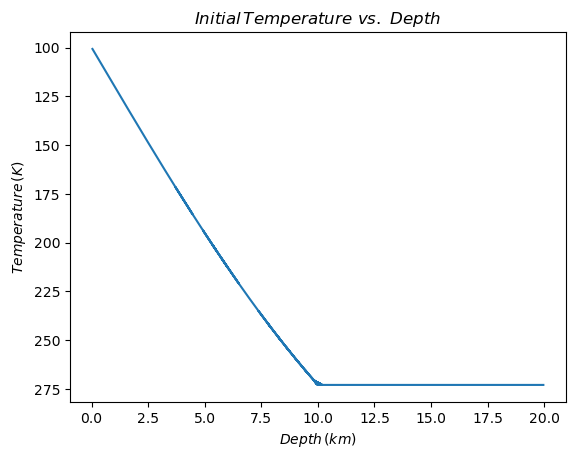

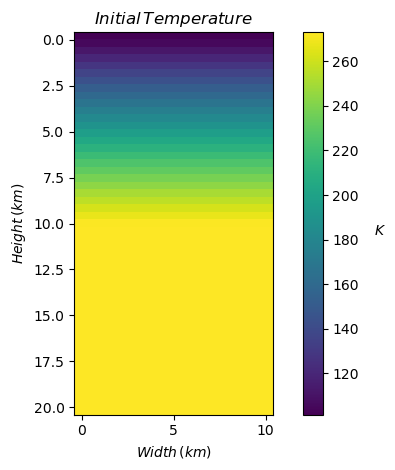

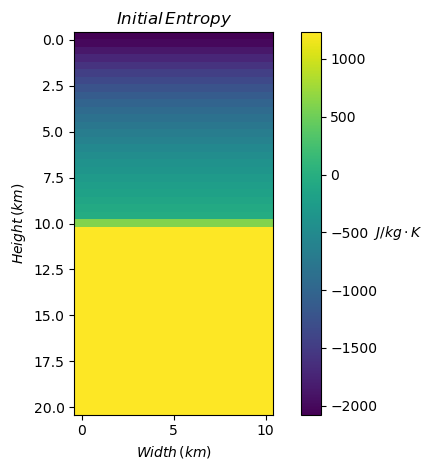

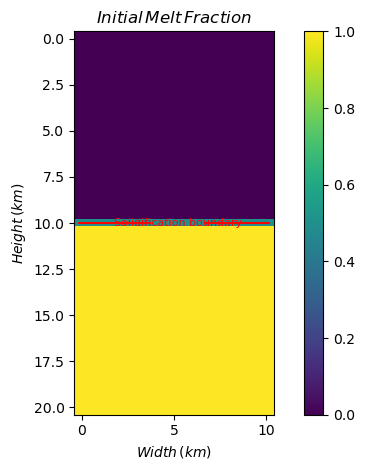

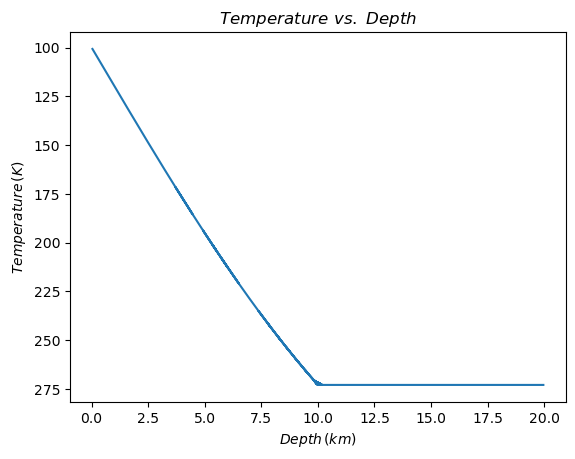

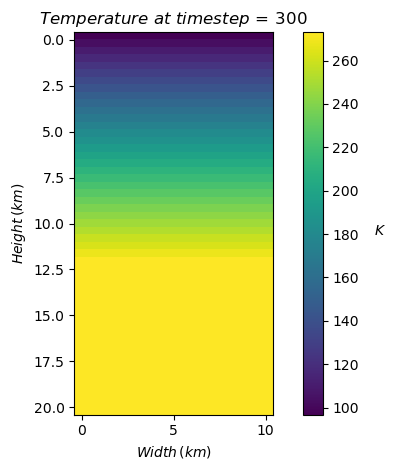

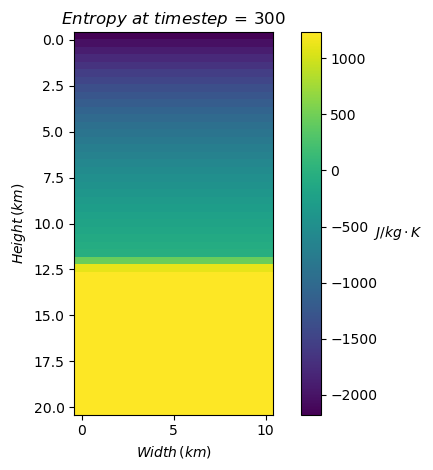

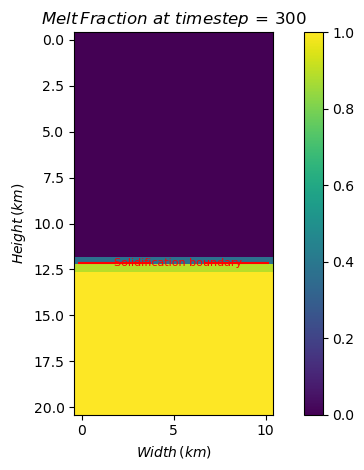

In [14]:
options = Dict()
options["latent heat of fusion"] = 3.36e5 #J/kg
options["specific heat"] = 2.1e3 # J/kg*K (ice)
options["Tm"] = 273.0 # K
options["To"] = 100.0 # K
options["thermal diffusivity"] = 2.2/(9e2*options["specific heat"]) # m^2/s (ice)
options["ym"] = 1e4 # m 
grid,time_plot,topography,topography_melt,itime = run(options);

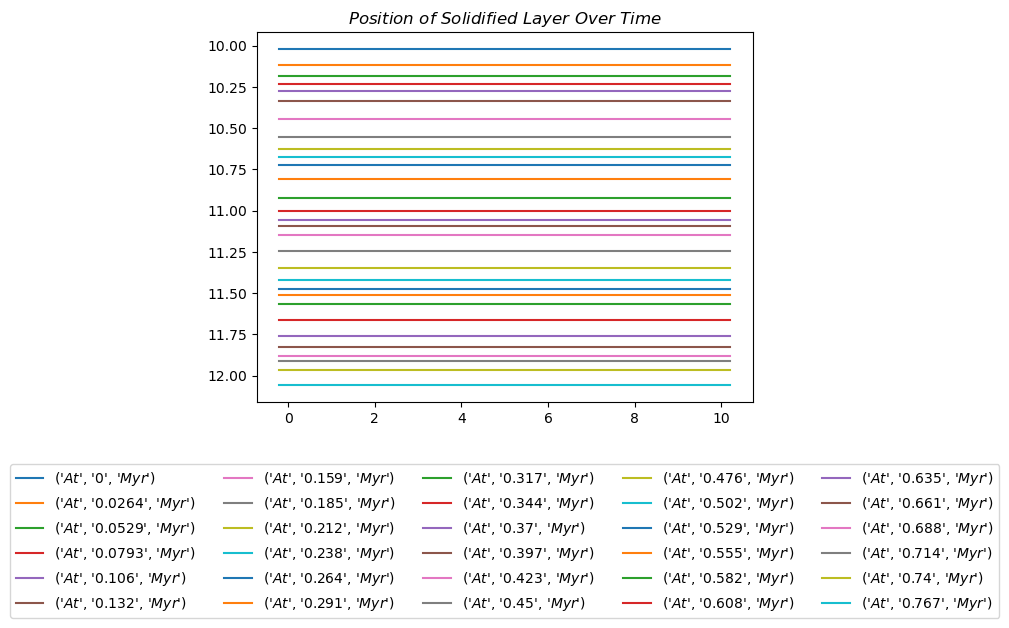

In [15]:
# Profile of ice-water inferface topograpgy over time from melt fraction
figure()
for i in 1:10:itime-1
    plot(grid.xc/1e3,topography[i]/1e3,label=(L"At",@sprintf("%.3g",time_plot[i]/3.15e7/1e6),L"Myr"))
end
title(L"Position\,\,of\,\,Solidified\,\,Layer\,\,Over\,\,Time")
gca().invert_yaxis()
# Legend is at the bottom
legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
show()

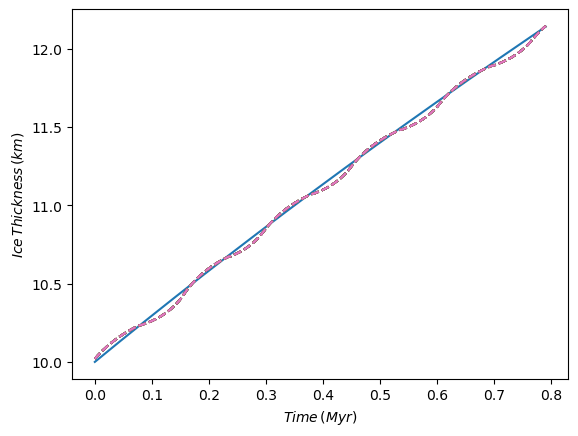

In [16]:
lambda1 = get_lambda1(options)
t = get_t(lambda1,options)
y = get_y.(lambda1,time_plot.+t,Ref(options))
figure()
plot(time_plot/3.15e7/1e6,y/1e3,"-",label="Stefan Solution")
plot(time_plot/3.15e7/1e6,topography/1e3,"--",label="Numerical Solution")
gca().set_ylabel(L"Ice\,Thickness\,(km)")
gca().set_xlabel(L"Time\,(Myr)")
# legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
show()

In [ ]:
# # Profile of ice-water inferface topograpgy over time
# figure()
# for i in 1:1:itime-1
#     plot(grid.xc/1000,topography[i]/1000,label=(L"At",@sprintf("%.3g",time_plot[i]/3.15e7/1e3),L"kyr"))
# end
# title(L"Position\,\,of\,\,Solidified\,\,Layer\,\,Over\,\,Time")
# gca().invert_yaxis()
# # Legend is at the bottom
# legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
# gca().set_ylim([9e3/1e3,1.1e4/1e3])
# show()

In [ ]:
    # figure()
    # title(L"Temperature\,\,vs.\,\,Depth")
    # plot(markers.scalars[markers.scalarFields["T"],1:markers.nmark],markers.x[2,1:markers.nmark]/1000)
    # gca().invert_yaxis()
    # gca().set_ylabel(L"Depth\,(km)")
    # gca().set_xlabel(L"Temperature\,(K)")
    # show()
    
    # figure()
    # title(L"Temperature\,\,Profile")
    # scatter(markers.x[1,1:markers.nmark]/1000,markers.x[2,1:markers.nmark]/1000,c=markers.scalars[markers.scalarFields["T"],1:markers.nmark],s=0.1,cmap="viridis")
    # colorbar().set_label(label=L"K",rotation=0,labelpad=15)
    # gca().invert_yaxis()
    # gca().set_aspect("equal")
    # gca().set_ylabel(L"Height\,(km)")
    # gca().set_xlabel(L"Width\,(km)")
    # # tight_layout()
    # show()

    # figure()
    # title(L"Entropy,\,Profile")
    # scatter(markers.x[1,1:markers.nmark]/1000,markers.x[2,1:markers.nmark]/1000,c=markers.scalars[markers.scalarFields["S"],1:markers.nmark],s=0.1,cmap="viridis")
    # contour(markers.x[1,1:markers.nmark]/1000,markers.x[2,1:markers.nmark]/1000,c=markers.scalars[markers.scalarFields["X"],1:markers.nmark])
    # colorbar().set_label(label=L"K",rotation=0,labelpad=15)
    # gca().invert_yaxis()
    # gca().set_aspect("equal")
    # gca().set_ylabel(L"Height\,(km)")
    # gca().set_xlabel(L"Width\,(km)")
    # # tight_layout()
    # show()

         # figure()
# title(L"Entropy\,\,Profile")
# scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["S"],:],s=0.1,cmap="viridis")
# colorbar().set_label(label=L"J/K")
# gca().invert_yaxis()
# # gca().set_aspect("equal")
# gca().set_ylabel(L"Height\,(km)")
# gca().set_xlabel(L"Width\,(km)")
# show()

    # figure()
    # title(L"Melt\,Fraction\,\,Profile")
    # plot(grid.xc/1000,i_ocean_ice_interface/1000,"-")
    # contour(markers.x[1,1:markers.nmark]/1000,markers.x[2,1:markers.nmark]/1000,c=markers.scalars[markers.scalarFields["X"],1:markers.nmark])
    # colorbar().set_label(label=L"K",rotation=0,labelpad=15)
    # gca().invert_yaxis()
    # gca().set_aspect("equal")
    # gca().set_ylabel(L"Height\,(km)")
    # gca().set_xlabel(L"Width\,(km)")
    # # tight_layout()
    # show()

In [ ]:
# figure()
# title(L"Initial\,\,Model\,\,Schematic")
# pcolor(grid.xc/1000,grid.yc/1000,i_mat,cmap="viridis")
# colorbar().set_label(label=L"material(id)",rotation=0,labelpad=35)
# gca().invert_yaxis()
# gca().set_aspect("equal")
# gca().set_ylabel(L"Height\,(km)",rotation=0,labelpad=30)
# gca().set_xlabel(L"Width\,(km)")
# # gca().yaxis.set_label_position("left")
# gca().spines["top"].set_visible(false) # Hide the top edge of the axis
# gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# # gca().yaxis.tick_right()
# gca().xaxis.set_ticks_position("bottom")
# gca().yaxis.set_ticks_position("left")
# gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
# gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
# gca().spines["top"].set_color("none") # Remove the top axis boundary
# gca().spines["right"].set_color("none") # Remove the right axis boundary
# tight_layout()
# show()

# figure()
# title(L"Temperature\,\,Profile")
# scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["T"],:],s=0.1,cmap="viridis")
# colorbar().set_label(label=L"K",rotation=0,labelpad=15)
# gca().invert_yaxis()
# gca().set_aspect("equal")
# gca().set_ylabel(L"Height\,(km)",rotation=0,labelpad=30)
# gca().set_xlabel(L"Width\,(km)")
# # gca().yaxis.set_label_position("left")
# gca().spines["top"].set_visible(false) # Hide the top edge of the axis
# gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# # gca().yaxis.tick_right()
# gca().xaxis.set_ticks_position("bottom")
# gca().yaxis.set_ticks_position("left")
# gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
# gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
# gca().spines["top"].set_color("none") # Remove the top axis boundary
# gca().spines["right"].set_color("none") # Remove the right axis boundary
# tight_layout()
# show()

# figure()
# title(L"Entropy\,\,Profile")
# scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["S"],:],s=0.1,cmap="viridis")
# colorbar().set_label(label=L"J/K",rotation=0,labelpad=15)
# gca().invert_yaxis()
# # gca().set_aspect("equal")
# gca().set_ylabel(L"Height\,(km)",rotation=0,labelpad=30)
# gca().set_xlabel(L"Width\,(km)")
# # gca().yaxis.set_label_position("left")
# gca().spines["top"].set_visible(false) # Hide the top edge of the axis
# gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# # gca().yaxis.tick_right()
# gca().xaxis.set_ticks_position("bottom")
# gca().yaxis.set_ticks_position("left")
# gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
# gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
# gca().spines["top"].set_color("none") # Remove the top axis boundary
# gca().spines["right"].set_color("none") # Remove the right axis boundary
# tight_layout()
# show()

# # figure()
# # title(L"q_{cond}\,\,at\,\,vx")
# # pcolor(q_cond_x,cmap="viridis")
# # colorbar().set_label(label=L"q_{vx}",rotation=0,labelpad=15)
# # gca().invert_yaxis()
# # gca().spines["top"].set_visible(false) # Hide the top edge of the axis
# # gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# # gca().xaxis.set_ticks_position("bottom")
# # gca().yaxis.set_ticks_position("left")
# # gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
# # gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
# # gca().spines["top"].set_color("none") # Remove the top axis boundary
# # gca().spines["right"].set_color("none") # Remove the right axis boundary
# # tight_layout()
# # show()

# # figure()
# # title(L"q_{cond}\,\,at\,\,vy")
# # pcolor(q_cond_y,cmap="viridis")
# # colorbar().set_label(label=L"q_{vy}",rotation=0,labelpad=15)
# # gca().invert_yaxis()
# # gca().spines["top"].set_visible(false) # Hide the top edge of the axis
# # gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# # gca().xaxis.set_ticks_position("bottom")
# # gca().yaxis.set_ticks_position("left")
# # gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
# # gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
# # gca().spines["top"].set_color("none") # Remove the top axis boundary
# # gca().spines["right"].set_color("none") # Remove the right axis boundary
# # tight_layout()
# # show()